In [224]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

In [225]:
def gaussian(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

def initialize_centers(data, num_centers):
    kmeans = KMeans(n_clusters=num_centers, random_state=0)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    std_devs = np.zeros(num_centers)
    for i in range(num_centers):
        std_devs[i] = np.std(data[np.where(kmeans.labels_ == i)])
    return centers, std_devs, kmeans.labels_

class RBFNetwork:
    def __init__(self, num_rbf, learning_rate):
        self.num_rbf = num_rbf
        self.learning_rate = learning_rate
        self.centers = None
        self.std_devs = None
        self.weights = None
        self.bias = None
        self.labels = None

    def fit(self, X, y):
        self.centers, self.std_devs, self.labels = initialize_centers(X, self.num_rbf)
        # Initialize weights and bias randomly
        self.weights = np.random.randn(self.num_rbf)
        self.bias = np.random.randn()

    def rbf(self, x, c, s):
        return gaussian(x, c, s)

    def predict(self, X):
        predictions = []
        for x in X:
            rbf_outputs = np.array([self.rbf(x, c, s) for c, s in zip(self.centers, self.std_devs)])
            predictions.append(np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias)
        return np.array(predictions)

    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                # Forward pass
                rbf_outputs = np.array([self.rbf(X[i], c, s) for c, s in zip(self.centers, self.std_devs)])
                predicted_output = np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias
                loss = (predicted_output - y[i][0]) ** 2

                # Backward pass
                error = predicted_output - y[i][0]
                self.weights -= (self.learning_rate * error * rbf_outputs).reshape(-1,)
                self.bias -= self.learning_rate * error
            if epoch%50 == 0:
                print(f'Epoch {epoch}, Sample {i}, Loss: {loss:.4f}')

In [226]:
# Plot K-means clustering results
def plot_kmeans_clustering(X, centers, kmeans_labels):
    plt.scatter(X, np.zeros_like(X), c=kmeans_labels, cmap='viridis', label='Clustered Data')
    plt.scatter(centers, np.zeros_like(centers), color='red', s=100, marker='x', label='Centers')
    plt.title("K-means Clustering of RBF Centers")
    plt.xlabel("X")
    plt.legend()
    plt.show()

Epoch 0, Sample 49, Loss: 1.1902
Epoch 50, Sample 49, Loss: 0.1117
Epoch 100, Sample 49, Loss: 0.0815
Epoch 150, Sample 49, Loss: 0.0656


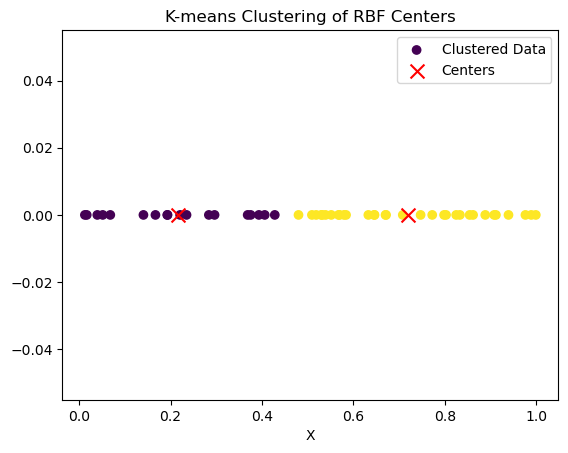

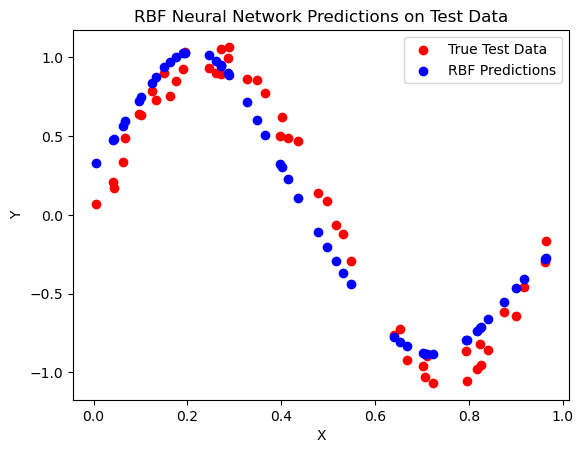

In [227]:
# Generate synthetic test data
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
Y = np.sin(2 * np.pi * X) + noise

# Reshape X and Y for the model
X = X.reshape(-1, 1)  # Reshape X to be a 2D array for the RBF network
Y = Y.reshape(-1, 1)  # Reshape Y for consistency

# Split the data into training and testing sets (e.g., 50% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Initialize and train the RBF network
num_rbf = 2
learning_rate = 0.01

# Initialize and train the RBF network on training data
rbf_network = RBFNetwork(num_rbf=num_rbf, learning_rate=learning_rate)
rbf_network.fit(X_train, Y_train)
rbf_network.train(X_train, Y_train, epochs=200)

# After fitting the RBF network, plot the clustering result for training data
plot_kmeans_clustering(X_train, rbf_network.centers, rbf_network.labels)

# Test predictions on the test set
predictions = rbf_network.predict(X_test)

# Plotting the results
plt.scatter(X_test, Y_test, color='red', label='True Test Data')
plt.scatter(X_test, predictions, color='blue', label='RBF Predictions')
plt.legend()
plt.title("RBF Neural Network Predictions on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# Pytorch

In [228]:
# Define the RBF Layer with dynamic initialization of centers and betas
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, centers, std_devs):
        super(RBFLayer, self).__init__()
        # Use the centers and std_devs from k-means initialization
        self.centers = nn.Parameter(torch.Tensor(centers))  # RBF centers
        self.beta = nn.Parameter(torch.Tensor(1 / (2 * std_devs**2)))  # Use std_devs to initialize beta

    def forward(self, x):
        x = x.unsqueeze(1)
        centers = self.centers.unsqueeze(0)
        dist = torch.sum((x - centers) ** 2, dim=2)
        return torch.exp(-self.beta * dist)

# Define RBF Network
class RBFNetwork(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, centers, std_devs):
        super(RBFNetwork, self).__init__()
        self.rbf_layer = RBFLayer(in_features, hidden_features, centers, std_devs)
        self.fc_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        return self.fc_layer(rbf_output)

Epoch [50/10000], Loss: 0.4033
Epoch [100/10000], Loss: 0.2342
Epoch [150/10000], Loss: 0.1451
Epoch [200/10000], Loss: 0.0917
Epoch [250/10000], Loss: 0.0590
Epoch [300/10000], Loss: 0.0389
Epoch [350/10000], Loss: 0.0266
Epoch [400/10000], Loss: 0.0190
Epoch [450/10000], Loss: 0.0143
Epoch [500/10000], Loss: 0.0114
Epoch [550/10000], Loss: 0.0096
Epoch [600/10000], Loss: 0.0085
Epoch [650/10000], Loss: 0.0078
Epoch [700/10000], Loss: 0.0074
Epoch [750/10000], Loss: 0.0071
Epoch [800/10000], Loss: 0.0070
Epoch [850/10000], Loss: 0.0069
Epoch [900/10000], Loss: 0.0068
Epoch [950/10000], Loss: 0.0068
Epoch [1000/10000], Loss: 0.0067
Epoch [1050/10000], Loss: 0.0067
Epoch [1100/10000], Loss: 0.0067
Epoch [1150/10000], Loss: 0.0067
Epoch [1200/10000], Loss: 0.0067
Epoch [1250/10000], Loss: 0.0067
Epoch [1300/10000], Loss: 0.0067
Epoch [1350/10000], Loss: 0.0067
Epoch [1400/10000], Loss: 0.0067
Epoch [1450/10000], Loss: 0.0067
Epoch [1500/10000], Loss: 0.0066
Epoch [1550/10000], Loss: 0.00

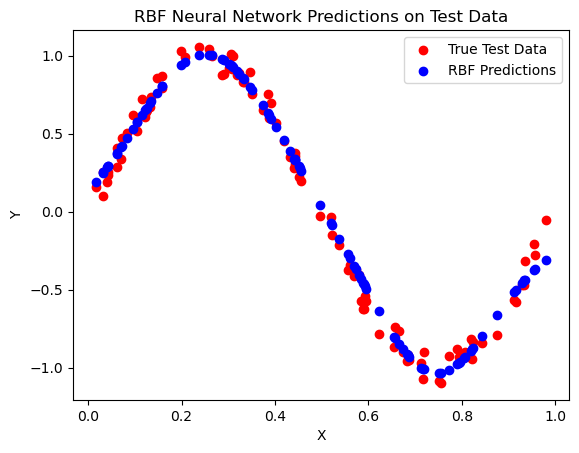

In [229]:
# Generate synthetic test data
NUM_SAMPLES = 200
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
Y = np.sin(2 * np.pi * X) + noise

# Reshape X and Y for the model
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

# Split the data into training and testing sets (50% training, 50% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Use k-means to initialize centers and standard deviations
centers, std_devs, labels = initialize_centers(X_train, num_rbf)

# Convert the centers and std_devs to torch tensors
centers_tensor = torch.Tensor(centers)
std_devs_tensor = torch.Tensor(std_devs)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.FloatTensor(Y_test)

# Set up the model
num_rbf = 2  # Number of RBF neurons
input_dim = 1
output_dim = 1

# Initialize random centers for RBFs
centers = torch.rand(num_rbf, input_dim)

# Initialize the RBF network
model = RBFNetwork(input_dim, num_rbf, output_dim, centers_tensor, std_devs_tensor)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Convert predictions back to numpy for plotting
predictions = predictions.numpy()

# Plotting the results
plt.scatter(X_test, Y_test, color='red', label='True Test Data')
plt.scatter(X_test, predictions, color='blue', label='RBF Predictions')
plt.legend()
plt.title("RBF Neural Network Predictions on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()